In [1]:
# Import Required Libraries

import warnings
warnings.filterwarnings('ignore')  # Suppress all warnings

import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import psutil

In [2]:
# Load and Preprocess Images from Directory

def load_and_preprocess_images(image_dir, target_size=(224, 224)):
    images, labels = [], []
    
    for class_name in sorted(os.listdir(image_dir)):
        class_dir = os.path.join(image_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
            
        for filename in os.listdir(class_dir):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(class_dir, filename)
                try:
                    img = Image.open(img_path).convert('RGB')
                    img = img.resize(target_size)
                    img_array = np.array(img, dtype=np.float32) / 255.0
                    
                    images.append(img_array)
                    labels.append(class_name)
                except Exception as e:
                    print(f"Skipping {img_path}: {e}")
    
    print(f"✅ Loaded {len(images)} images from {image_dir}")
    return np.array(images), np.array(labels)

# Example: Folder structure -> dataset/train/class1/*.jpg, dataset/train/class2/*.jpg
X, y = load_and_preprocess_images('dataset_4_100img')


✅ Loaded 467 images from dataset_4_100img


In [3]:
# Save dataset as NPZ (compressed)
np.savez_compressed('dataset_compressed.npz', images=X, labels=y)
print("✅ Saved dataset_compressed.npz")

✅ Saved dataset_compressed.npz


In [4]:
import psutil

In [5]:
file_path = 'dataset_compressed.npz'
file_size_gb = os.path.getsize(file_path) / (1024**3)
print(f"📦 File size: {file_size_gb:.2f} GB")

# Current system memory usage
process = psutil.Process()
memory_gb = process.memory_info().rss / (1024**3)
print(f"💾 Current RAM usage: {memory_gb:.2f} GB")


📦 File size: 0.03 GB
💾 Current RAM usage: 0.48 GB


In [6]:
# Step 5A: Load NPZ normally
data = np.load('dataset_compressed.npz')
X = data['images']
y = data['labels']

print(f"✅ Loaded {len(X)} images from NPZ in seconds")
print("🖼️ Image shape:", X.shape)
print("🏷️ Unique classes:", np.unique(y))


✅ Loaded 467 images from NPZ in seconds
🖼️ Image shape: (467, 224, 224, 3)
🏷️ Unique classes: ['Bacterial_Pneu' 'COVID' 'Normal' 'Viral_Pneu']


In [7]:
# Split the data
from sklearn.model_selection import train_test_split


In [8]:
# Step 6: Split data into train, validation, test sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_val_enc = le.transform(y_val)
y_test_enc = le.transform(y_test)

class_names = le.classes_
print("✅ Encoded class names:", class_names)


✅ Encoded class names: ['Bacterial_Pneu' 'COVID' 'Normal' 'Viral_Pneu']


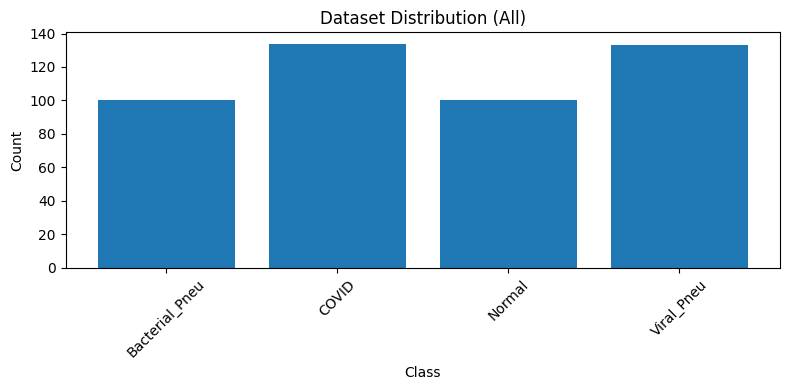

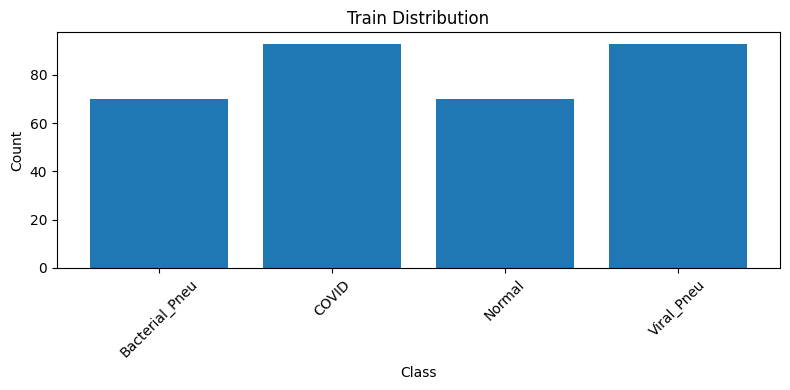

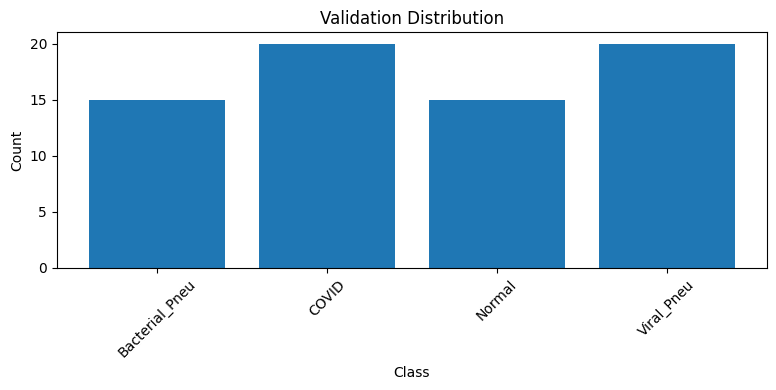

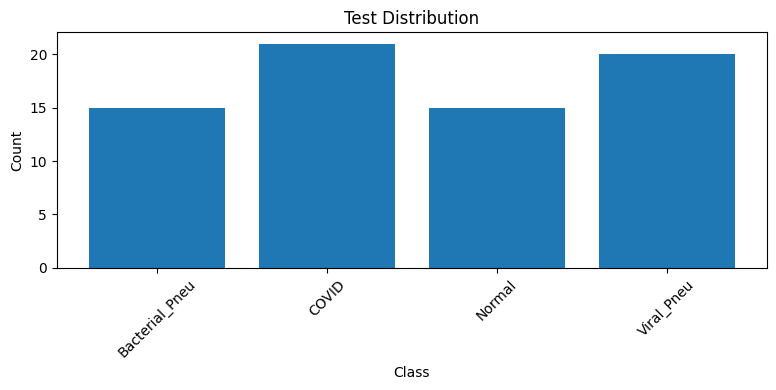

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Overall distribution from original labels y
unique_all, counts_all = np.unique(y, return_counts=True)

plt.figure(figsize=(8, 4))
plt.bar(unique_all, counts_all)
plt.title("Dataset Distribution (All)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Split-wise distribution (train/val/test)
def plot_split_dist(split_labels, title):
    u, c = np.unique(split_labels, return_counts=True)
    plt.figure(figsize=(8, 4))
    plt.bar(u, c)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Convert encoded labels back to class names for plotting
plot_split_dist(class_names[y_train_enc], "Train Distribution")
plot_split_dist(class_names[y_val_enc], "Validation Distribution")
plot_split_dist(class_names[y_test_enc], "Test Distribution")

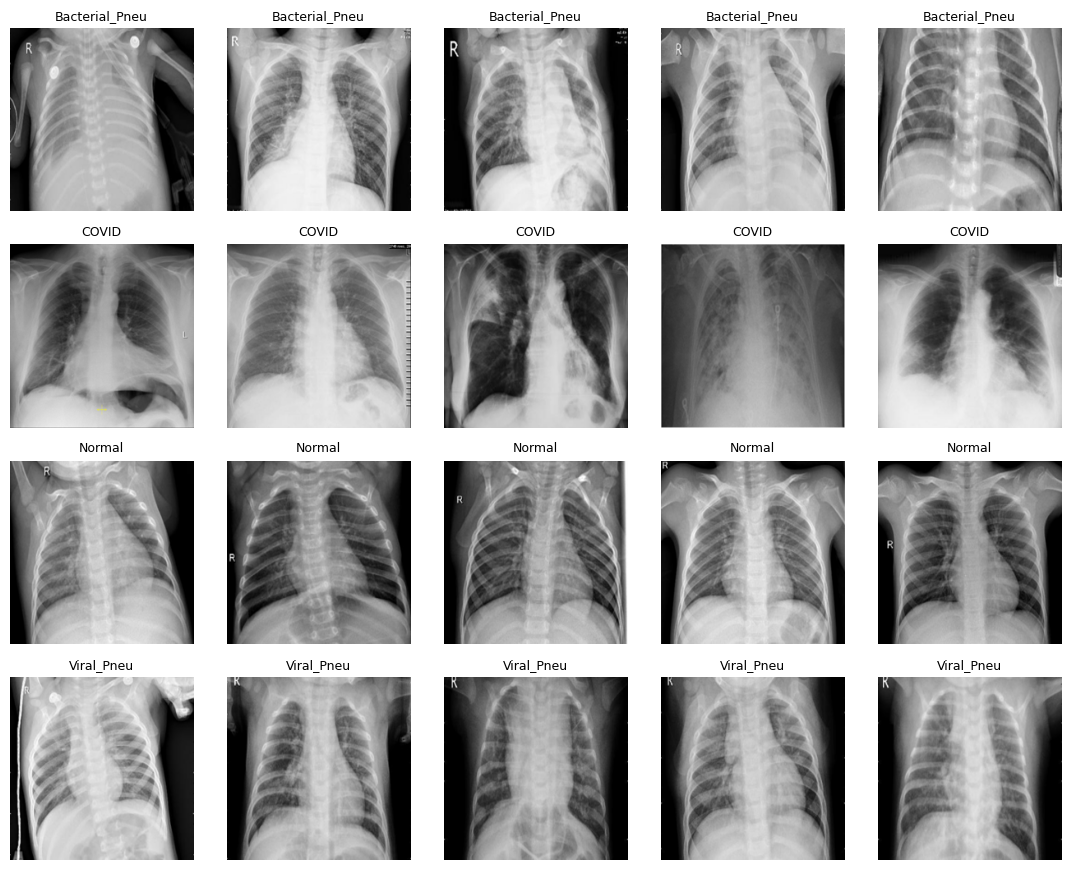

In [10]:
import math

def show_class_grid(X_data, y_enc, class_names, samples_per_class=5):
    plt.figure(figsize=(samples_per_class * 2.2, len(class_names) * 2.2))
    idx = 1
    for ci, cname in enumerate(class_names):
        indices = np.where(y_enc == ci)[0]
        if len(indices) == 0:
            continue
        chosen = np.random.choice(indices, size=min(samples_per_class, len(indices)), replace=False)
        for j, k in enumerate(chosen):
            plt.subplot(len(class_names), samples_per_class, idx)
            plt.imshow(X_data[k])
            plt.title(cname, fontsize=9)
            plt.axis('off')
            idx += 1
    plt.tight_layout()
    plt.show()

show_class_grid(X_train, y_train_enc, class_names, samples_per_class=5)


2025-10-30 09:28:33.523792: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-10-30 09:28:33.523852: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-10-30 09:28:33.523884: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-10-30 09:28:33.530364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

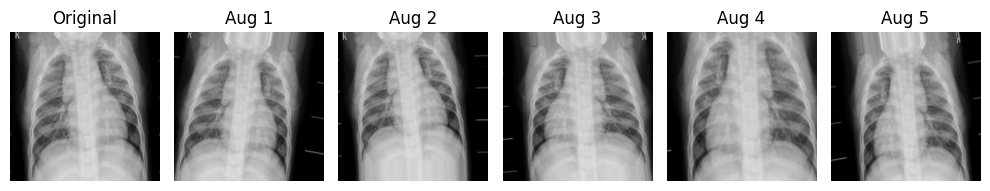

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# If you don't already have datagen, define a simple one:
if 'datagen' not in globals():
    datagen = ImageDataGenerator(
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(X_train)

# Pick one image and visualize several augmented versions
sample_idx = np.random.randint(0, len(X_train))
sample_img = X_train[sample_idx:sample_idx+1]

plt.figure(figsize=(10, 2.2))
plt.subplot(1, 6, 1)
plt.imshow(sample_img[0])
plt.title("Original")
plt.axis('off')

aug_iter = datagen.flow(sample_img, batch_size=1)
for i in range(2, 7):
    aug_img = next(aug_iter)[0]
    plt.subplot(1, 6, i)
    plt.imshow(aug_img)
    plt.title(f"Aug {i-1}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [12]:
from tensorflow.keras import layers, models

# Simple CNN Model
model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, y_train_enc,
    validation_data=(X_val, y_val_enc),
    batch_size=32,
    epochs=5
)


2025-10-30 09:28:35.721536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-30 09:28:35.727471: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-30 09:28:35.727541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-30 09:28:35.728530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-10-30 09:28:35.728586: I tensorflow/compile

Epoch 1/5


2025-10-30 09:28:37.512273: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2025-10-30 09:28:37.980455: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x793ea27c4630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-30 09:28:37.980511: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Quadro RTX 5000, Compute Capability 7.5
2025-10-30 09:28:37.986092: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-30 09:28:38.070664: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11/11 [==============================] - 3s 79ms/step - loss: 7.3830 - accuracy: 0.3742 - val_loss: 1.5262 - val_accuracy: 0.2429
Epoch 2/5
11/11 [==============================] - 0s 32ms/step - loss: 1.3506 - accuracy: 0.3282 - val_loss: 1.1250 - val_accuracy: 0.4857
Epoch 3/5
11/11 [==============================] - 0s 33ms/step - loss: 0.8000 - accuracy: 0.7055 - val_loss: 1.0150 - val_accuracy: 0.6143
Epoch 4/5
11/11 [==============================] - 0s 33ms/step - loss: 0.6052 - accuracy: 0.7546 - val_loss: 0.6343 - val_accuracy: 0.7429
Epoch 5/5
11/11 [==============================] - 0s 32ms/step - loss: 0.3843 - accuracy: 0.8528 - val_loss: 0.5989 - val_accuracy: 0.7000


In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=False
)
datagen.fit(X_train)

history_aug = model.fit(
    datagen.flow(X_train, y_train_enc, batch_size=32),
    validation_data=(X_val, y_val_enc),
    epochs=50
)


Epoch 1/50
11/11 [==============================] - 3s 216ms/step - loss: 0.8973 - accuracy: 0.6196 - val_loss: 0.7310 - val_accuracy: 0.6429
Epoch 2/50
11/11 [==============================] - 2s 202ms/step - loss: 1.0345 - accuracy: 0.6166 - val_loss: 0.7476 - val_accuracy: 0.6571
Epoch 3/50
11/11 [==============================] - 2s 203ms/step - loss: 0.8655 - accuracy: 0.6380 - val_loss: 0.5809 - val_accuracy: 0.8000
Epoch 4/50
11/11 [==============================] - 2s 211ms/step - loss: 0.9983 - accuracy: 0.6104 - val_loss: 0.7698 - val_accuracy: 0.7429
Epoch 5/50
11/11 [==============================] - 2s 214ms/step - loss: 0.8643 - accuracy: 0.6626 - val_loss: 0.6136 - val_accuracy: 0.6857
Epoch 6/50
11/11 [==============================] - 2s 203ms/step - loss: 0.7379 - accuracy: 0.6810 - val_loss: 0.5005 - val_accuracy: 0.7714
Epoch 7/50
11/11 [==============================] - 2s 201ms/step - loss: 0.6807 - accuracy: 0.7239 - val_loss: 0.5595 - val_accuracy: 0.7429
Epoch 

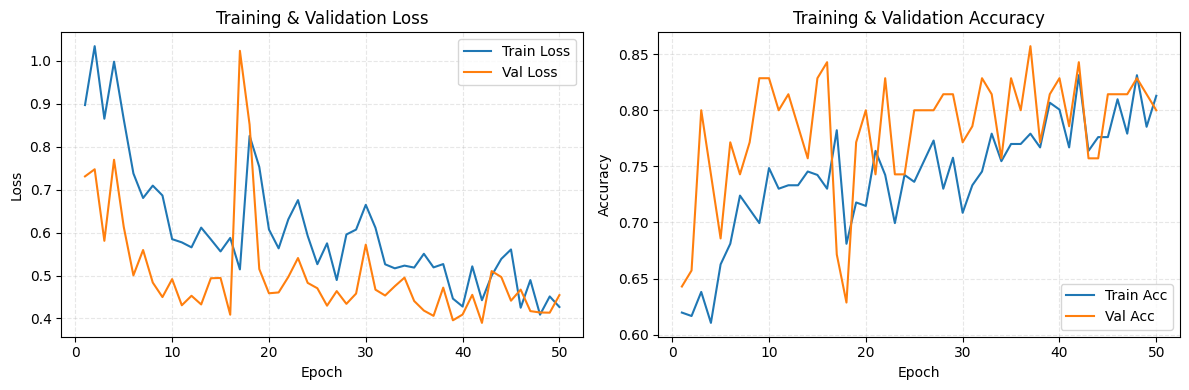

In [14]:
# Side-by-side Training Curves (Loss & Accuracy)

train_history = None
if 'history_aug' in globals():
    train_history = history_aug
elif 'history' in globals():
    train_history = history

if train_history is None:
    print("No history object found. Train the model first.")
else:
    h = train_history.history
    epochs = range(1, len(h.get('loss', [])) + 1)

    # pick correct accuracy keys if needed
    acc_key = 'accuracy' if 'accuracy' in h else ('acc' if 'acc' in h else None)
    val_acc_key = 'val_accuracy' if 'val_accuracy' in h else ('val_acc' if 'val_acc' in h else None)

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # ---- Left: Loss ----
    axes[0].plot(epochs, h.get('loss', []), label='Train Loss')
    if 'val_loss' in h:
        axes[0].plot(epochs, h['val_loss'], label='Val Loss')
    axes[0].set_title('Training & Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[0].grid(True, linestyle='--', alpha=0.3)

    # ---- Right: Accuracy ----
    if acc_key is not None:
        axes[1].plot(epochs, h.get(acc_key, []), label='Train Acc')
        if val_acc_key is not None and val_acc_key in h:
            axes[1].plot(epochs, h[val_acc_key], label='Val Acc')
        axes[1].set_title('Training & Validation Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].set_ylabel('Accuracy')
        axes[1].legend()
        axes[1].grid(True, linestyle='--', alpha=0.3)
    else:
        axes[1].axis('off')
        axes[1].text(0.5, 0.5, 'No accuracy metric found in history.',
                     ha='center', va='center')

    plt.tight_layout()
    plt.show()


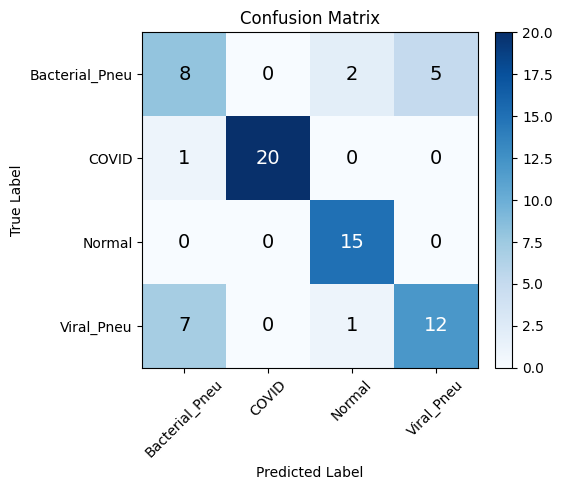

In [15]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

# Predict
y_prob = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_prob, axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test_enc, y_pred)

# Plot
plt.figure(figsize=(6, 5))
im = plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)  # 🔵 change colormap here
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Add colorbar
plt.colorbar(im, fraction=0.046, pad=0.04)

# Tick labels
plt.xticks(ticks=np.arange(len(class_names)), labels=class_names, rotation=45)
plt.yticks(ticks=np.arange(len(class_names)), labels=class_names)

# Annotate each cell
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j],
                 ha='center', va='center',
                 color='white' if cm[i, j] > thresh else 'black',
                 fontsize=14)

plt.tight_layout()
plt.show()


In [16]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test_enc, y_pred, target_names=class_names))


Classification Report:
                precision    recall  f1-score   support

Bacterial_Pneu       0.50      0.53      0.52        15
         COVID       1.00      0.95      0.98        21
        Normal       0.83      1.00      0.91        15
    Viral_Pneu       0.71      0.60      0.65        20

      accuracy                           0.77        71
     macro avg       0.76      0.77      0.76        71
  weighted avg       0.78      0.77      0.77        71



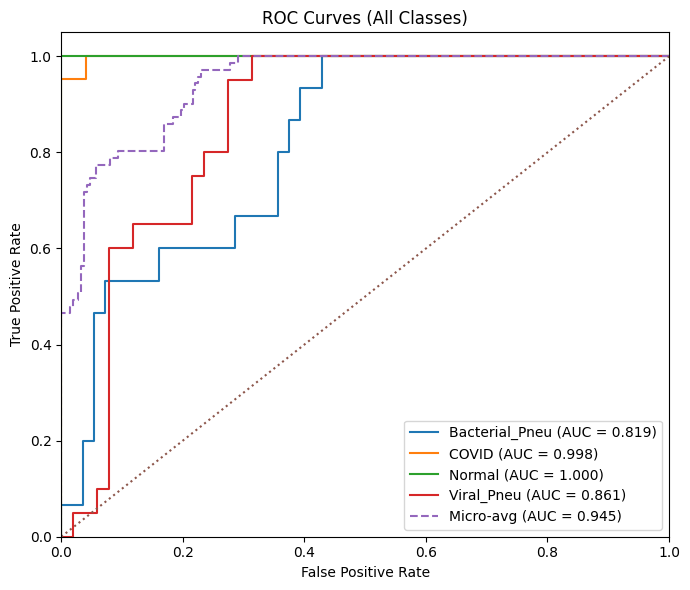

In [17]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# --- Prepare ---
n_classes = len(class_names)
y_test_bin = label_binarize(y_test_enc, classes=list(range(n_classes)))

# y_prob should be class probabilities with shape (N, n_classes)
# Fix binary case where model outputs (N, 1)
if y_prob.shape[1] == 1 and n_classes == 2:
    y_prob = np.hstack([1 - y_prob, y_prob])

# --- Compute per-class ROC and AUC ---
fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Micro-average
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Macro-average (average the AUCs of all classes)
roc_auc["macro"] = np.mean([roc_auc[i] for i in range(n_classes)])

# --- Plot all on a single figure ---
plt.figure(figsize=(7, 6))

# Per-class curves
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')

# Micro-average curve (dashed)
plt.plot(fpr["micro"], tpr["micro"], linestyle='--',
         label=f'Micro-avg (AUC = {roc_auc["micro"]:.3f})')

# Chance line
plt.plot([0, 1], [0, 1], linestyle=':')

plt.title('ROC Curves (All Classes)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc='lower right', ncol=1, frameon=True)
plt.tight_layout()
plt.show()


In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test_enc)
print(f"✅ Test Accuracy: {test_acc:.2f}")


3/3 [==============================] - 0s 10ms/step - loss: 0.5932 - accuracy: 0.7746
✅ Test Accuracy: 0.77


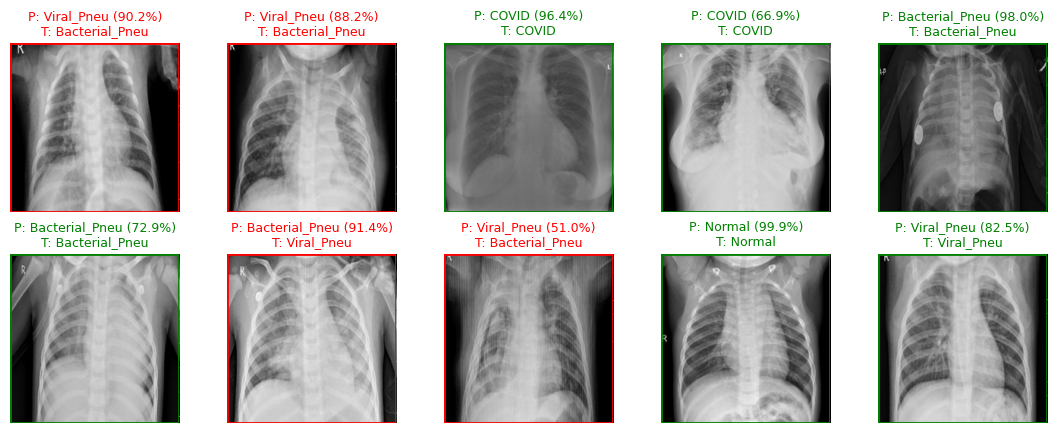

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

def show_predictions(X_data, y_true_enc, class_names, y_prob=None, rows=2, cols=5):
    idxs = np.random.choice(len(X_data), size=min(rows*cols, len(X_data)), replace=False)

    # If probabilities not provided, predict only the selected subset
    if y_prob is None:
        y_prob = model.predict(X_data[idxs], verbose=0)

    preds = np.argmax(y_prob, axis=1)
    confs = np.max(y_prob, axis=1)

    plt.figure(figsize=(cols * 2.2, rows * 2.2))
    for i, (img_idx, pred, conf) in enumerate(zip(idxs, preds, confs)):
        true_label_idx = y_true_enc[img_idx]
        true_label = class_names[true_label_idx]
        pred_label = class_names[pred]
        is_correct = (pred == true_label_idx)

        ax = plt.subplot(rows, cols, i + 1)
        ax.imshow(X_data[img_idx])
        ax.axis('off')

        # Title color: green if correct, red if misclassified
        title_color = 'green' if is_correct else 'red'
        title = f"P: {pred_label} ({conf*100:.1f}%)\nT: {true_label}"
        ax.set_title(title, fontsize=9, color=title_color)

        # Add a colored border (green for correct, red for misclassified)
        h, w = X_data[img_idx].shape[:2]
        rect = Rectangle((0, 0), w-1, h-1,
                         fill=False,
                         linewidth=2.0,
                         edgecolor=title_color)
        ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

# Use on test set
show_predictions(X_test, y_test_enc, class_names)


In [20]:
dataset_info = {
    'version': '1.0',
    'created': '2025-10-30',
    'num_samples': len(X),
    'preprocessing': 'resize_224_normalize',
    'class_names': list(class_names)
}

np.savez_compressed(
    'dataset_full_v1.npz',
    train_images=X_train,
    train_labels=y_train_enc,
    val_images=X_val,
    val_labels=y_val_enc,
    test_images=X_test,
    test_labels=y_test_enc,
    info=dataset_info
)

print("✅ Saved full structured dataset dataset_full_v1.npz")


✅ Saved full structured dataset dataset_full_v1.npz


In [21]:
data = np.load('dataset_full_v1.npz', allow_pickle=True)
info = data['info'].item()

print("ℹ️ Dataset Info:")
for k, v in info.items():
    print(f"{k}: {v}")


ℹ️ Dataset Info:
version: 1.0
created: 2025-10-30
num_samples: 467
preprocessing: resize_224_normalize
class_names: ['Bacterial_Pneu', 'COVID', 'Normal', 'Viral_Pneu']
